In [9]:
import cv2
import numpy as np
from PIL import Image,ImageEnhance
from IPython.display import display, clear_output
import imutils

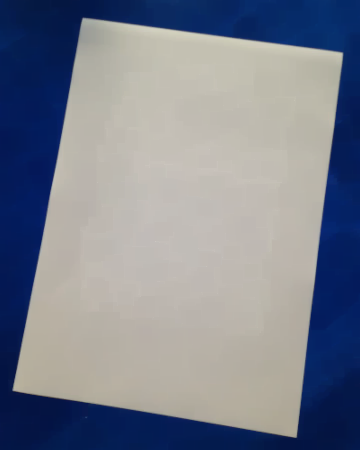

In [117]:
img = cv2.imread('document.jpg')
img_original = img.copy()
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
kernel = np.ones((5,5),np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations= 3)
display(Image.fromarray(img))

In [118]:
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (20,20,img.shape[1]-20,img.shape[0]-20)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

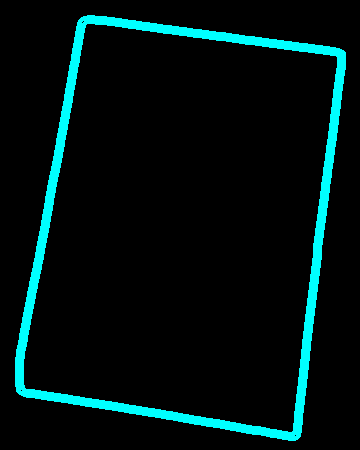

In [119]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (11, 11), 0)
# Edge Detection.
canny = cv2.Canny(gray, 0, 200)
canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
# Blank canvas.
con = np.zeros_like(img)
# Finding contours for the detected edges.
contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Keeping only the largest detected contour.
page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
con = cv2.drawContours(con, page, -1, (0, 255, 255), 3)
display(Image.fromarray(con))

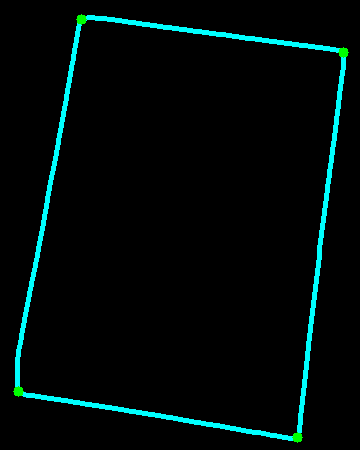

In [120]:
con = np.zeros_like(img)
# Loop over the contours.
for c in page:
  # Approximate the contour.
    epsilon = 0.02 * cv2.arcLength(c, True)
    corners = cv2.approxPolyDP(c, epsilon, True)
  # If our approximated contour has four points
    if len(corners) == 4:
        break
cv2.drawContours(con, c, -1, (0, 255, 255), 3)
cv2.drawContours(con, corners, -1, (0, 255, 0), 10)
corners = sorted(np.concatenate(corners).tolist())
display(Image.fromarray(con))

In [121]:
def biggest_contour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 5000:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest

def order_points(pts):
    points = biggest.reshape(4, 2)
    input_points = np.zeros((4, 2), dtype="float32")

    points_sum = points.sum(axis=1)
    input_points[0] = points[np.argmin(points_sum)]
    input_points[3] = points[np.argmax(points_sum)]

    points_diff = np.diff(points, axis=1)
    input_points[1] = points[np.argmin(points_diff)]
    input_points[2] = points[np.argmax(points_diff)]

In [122]:
pts = order_points(corners)
(tl, tr, br, bl) = pts
# Finding the maximum width.
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))
# Finding the maximum height.
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))

destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]

matrix = cv2.getPerspectiveTransform(input_points, converted_points)
final = cv2.warpPerspective(img_original, matrix, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LINEAR)

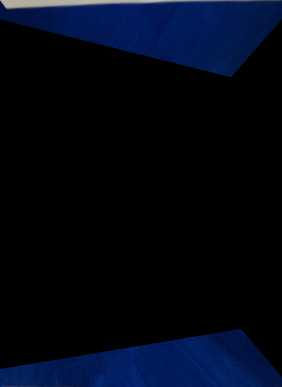

In [123]:
display(Image.fromarray(final))